In [1]:
# standard data science packages
import pandas as pd
import numpy as np
import math

# data viz imports
import matplotlib.pyplot as plt
import folium
import branca
import seaborn as sns

# file system imports
import os

# sklearn imports
from sklearn.model_selection import train_test_split

In [2]:
dataset = "361260"
seeds = range(5)
datafolder = "fulldata"
treemethod = "rf"
clustertype = "kmeans"
clustermodel = "linear"

In [3]:
base_path = f'../cluster-results/{treemethod}/{clustertype}/{clustermodel}'
color_map = {
    'elastic_nonnormed_nosquared_norank': 'black',
    'lime': '#71BEB7',
    'shap': 'orange',
    'lmdi_baseline': '#9B5DFF',
    'random': 'gray',
    'global_elastic_nonnormed_nosquared_norank': 'red'
}
methods_name = {
    'elastic_nonnormed_nosquared_norank': 'LMDI+',
    'lmdi_baseline': 'bLoTLA',
    'lime': 'LIME',
    'shap': 'TreeSHAP',
    'random': 'Random',
    'global_elastic_nonnormed_nosquared_norank': 'Global'
}

seed_means = []
seed_sds = []

# go through each of the subdirectories and read data
for seed in seeds:
    
    # check that the directory exists
    if not os.path.exists(base_path + f'/{dataset}/seed{seed}'):
        print(f"Directory {base_path}/{dataset}/seed{seed} does not exist")
        continue

    # get the data (removing the 'unnamed' column)
    mse_means = pd.read_csv(base_path + f'/{dataset}/seed{seed}/cluster_mse_mean.csv').iloc[:,1:]
    mse_sds = pd.read_csv(base_path + f'/{dataset}/seed{seed}/cluster_mse_sd.csv').iloc[:,1:]
    
    # convert sds to ses by dividing by sqrt(n)
    mse_sds = mse_sds / np.sqrt(100)
    
    # get the methods we care about
    methods = ["elastic_nonnormed_nosquared_norank",
               'lmdi_baseline', 'lime', 'shap',
               "global_elastic_nonnormed_nosquared_norank", "random"]
    all_methods = []
    for method in methods:
        all_methods.append(method)
        
    # get the data for the methods we care about
    mse_means = mse_means[all_methods]
    mse_sds = mse_sds[all_methods]
    
    # append the data to the list
    seed_means.append(mse_means)
    seed_sds.append(mse_sds)
# take the average of the dataframes in the list
mean_df = pd.concat(seed_means).groupby(level=0).mean()
sd_df = pd.concat(seed_sds).groupby(level=0).mean()

In [4]:
mean_df

,elastic_nonnormed_nosquared_norank,lmdi_baseline,lime,shap,global_elastic_nonnormed_nosquared_norank,random
0,0.074403,0.074403,0.074403,0.074403,0.074403,0.074403
1,0.065229,0.066809,0.065388,0.064816,0.074377,0.074952
2,0.057562,0.061390,0.060902,0.052921,0.074348,0.075482
3,0.046724,0.059429,0.057511,0.049141,0.074118,0.076044
4,0.045012,0.053669,0.055894,0.047256,0.074273,0.076418
5,0.044247,0.051526,0.055075,0.047126,0.074334,0.076648
6,0.044131,0.048787,0.054236,0.045440,0.074526,0.077108
7,0.042946,0.048548,0.052072,0.047809,0.074462,0.077822
8,0.042962,0.046869,0.051768,0.047529,0.074528,0.078238
9,0.042149,0.297725,0.050432,0.047243,0.074325,0.078489


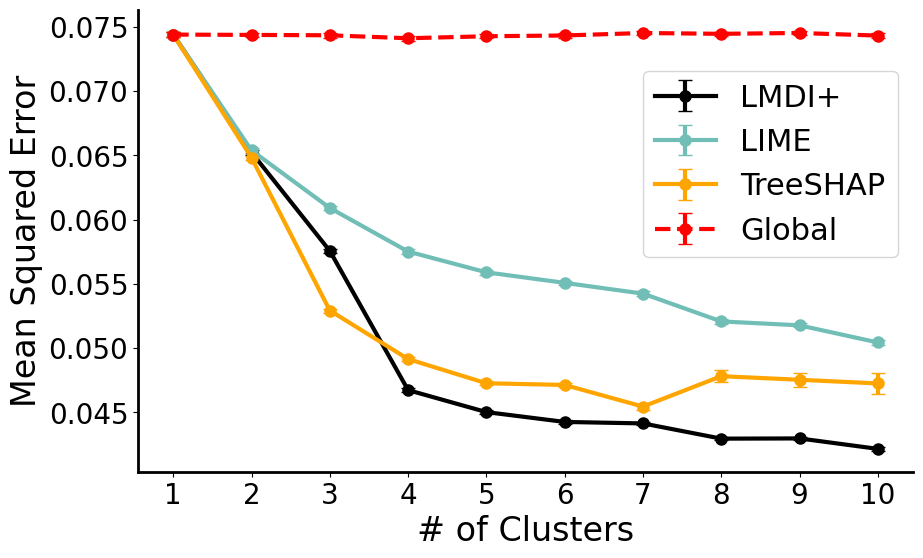

In [23]:
### plot the data
# The x-axis values
x_values = np.array(range(1, 11), dtype = int)

# create the plot
plt.figure(figsize=(10, 6))
plt.rcParams['axes.edgecolor'] = 'black'
plt.rcParams['axes.linewidth'] = 2.0
# take off top and right spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# plot each column as a separate line with error bars
for col in mean_df.columns:
    if methods_name[col] in ['Random', 'bLoTLA'] :
        continue
    if methods_name[col] == "Global":
        linestyle = "dashed"
    else:
        linestyle = "solid"
    plt.errorbar(x_values, mean_df[col], yerr=sd_df[col],
                 label=methods_name[col], color=color_map[col],
                capsize=5, fmt='o', linestyle=linestyle, linewidth=3, markersize=8)

# adding labels and title
plt.xlabel("# of Clusters", fontsize=24)
plt.ylabel("Mean Squared Error", fontsize=24)

# only put x-axis ticks on integers
plt.xticks(x_values)
# make x tick labels larger
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# locate legend on right with y = 0.07

plt.legend(loc='upper right', bbox_to_anchor=(1, 0.9), fontsize=22)

plt.savefig("images/subgroup_error.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [7]:
# read in the miami housing dataset
X_miami = np.loadtxt("../data_openml/X_361260.csv", delimiter=",")[1:,:]
print(X_miami.shape)
y_miami = np.loadtxt("../data_openml/y_361260.csv", delimiter=",")[1:]
cols_miami = ['LATITUDE', 'LONGITUDE', 'LND_SQFOOT', 'TOT_LVG_AREA',
              'SPEC_FEAT_VAL', 'RAIL_DIST', 'OCEAN_DIST', 'WATER_DIST',
              'CNTR_DIST', 'SUBCNTR_DI', 'HWY_DIST', 'age', 'avno60plus',
              'month_sold', 'structure_quality']

# read in shap values
shap_miami = np.loadtxt("../lfi-values/fulldata/rf/seed0/361260/shap.csv",
                        delimiter=",")

# read in lotla values
lotla_miami = np.loadtxt("../lfi-values/fulldata/rf/seed0/361260/" + \
    "elastic_nonnormed_nosquared_norank.csv", delimiter=",")

# split into train and test 50/50 with seed 0
_, X_miami, _, y_miami = train_test_split(X_miami, y_miami,
                                          test_size = 0.5, random_state = 0)

# read in cluster labels
base = f"../cluster-results/rf/kmeans/{clustermodel}/361260/seed0/"
labels_shap = np.loadtxt(base + "k4_shap_labels.csv", delimiter=",")
labels_lotla = np.loadtxt(base + \
    "k4_elastic_nonnormed_nosquared_norank_labels.csv", delimiter=",")

(13932, 15)


In [8]:
base = f"../cluster-results/rf/kmeans/{clustermodel}/361260/"
labels_shap0 = np.loadtxt(base + "seed0/k4_shap_labels.csv", delimiter=",")
labels_lotla0 = np.loadtxt(base + \
    "seed0/k4_elastic_nonnormed_nosquared_norank_labels.csv", delimiter=",")
labels_shap1 = np.loadtxt(base + "seed1/k4_shap_labels.csv", delimiter=",")
labels_lotla1 = np.loadtxt(base + \
    "seed1/k4_elastic_nonnormed_nosquared_norank_labels.csv", delimiter=",")
labels_shap2 = np.loadtxt(base + "seed2/k4_shap_labels.csv", delimiter=",")
labels_lotla2 = np.loadtxt(base + \
    "seed2/k4_elastic_nonnormed_nosquared_norank_labels.csv", delimiter=",")
labels_shap3 = np.loadtxt(base + "seed3/k4_shap_labels.csv", delimiter=",")
labels_lotla3 = np.loadtxt(base + \
    "seed3/k4_elastic_nonnormed_nosquared_norank_labels.csv", delimiter=",")
labels_shap4 = np.loadtxt(base + "seed4/k4_shap_labels.csv", delimiter=",")
labels_lotla4 = np.loadtxt(base + \
    "seed4/k4_elastic_nonnormed_nosquared_norank_labels.csv", delimiter=",")

In [9]:
labels_shap0

array([3., 3., 2., ..., 0., 3., 0.])

In [10]:
labels_shap3

array([1., 1., 0., ..., 1., 3., 1.])

In [ ]:
# get average feature values per cluster for lotla
shap_clusters = pd.DataFrame(X_miami, columns = cols_miami)
shap_clusters['cluster'] = labels_shap
# for each feature, plot a boxplot of the feature values for each cluster
for col in cols_miami:
    fig, ax = plt.subplots()
    shap_clusters.boxplot(column = col, by = 'cluster', ax = ax)
    ax.set_title(col)
    ax.set_ylabel("Feature Value")
    ax.set_xlabel("Cluster")
    plt.suptitle("")
    plt.show()

In [ ]:
# make boxplot similar to above
plt.figure(figsize = (3.5, 5))
bp = sns.boxplot(x = shap_clusters['cluster'], y = y_miami)
# make colors of the boxes match the density plot
plt.title("Sale Price by Cluster", fontsize=16)
# make x ticks integers
plt.xticks(range(4), range(1, 5))
# hide legend
plt.legend([],[], frameon=False)
# make the tick labels bigger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# make labels bigger
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Sale Price (Log-USD)", fontsize=14)
plt.show()


In [13]:
# get average feature values per cluster for lotla
lotla_clusters = pd.DataFrame(X_miami, columns = cols_miami)
lotla_clusters['cluster'] = labels_lotla

In [ ]:
# for each feature, plot a boxplot of the feature values for each cluster
for col in cols_miami:
    fig, ax = plt.subplots()
    lotla_clusters.boxplot(column = col, by = 'cluster', ax = ax)
    ax.set_title(col)
    ax.set_ylabel("Feature Value")
    ax.set_xlabel("Cluster")
    plt.suptitle("")
    plt.show()

In [ ]:
# get stacked density plots of each feature for each cluster, similar to ggridges in R
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}
plt.figure(figsize = (7, 5))
for cluster in range(4):
    sns.kdeplot(lotla_clusters["TOT_LVG_AREA"][lotla_clusters['cluster'] == cluster],
                label = f"Cluster {cluster + 1}", color = color_map[cluster])
# add title
plt.title("Density Plot of Living Area by Cluster")
# add x-axis label
plt.xlabel("Total Living Area (Sq. Ft.)")
# add legend
plt.legend()
plt.show()

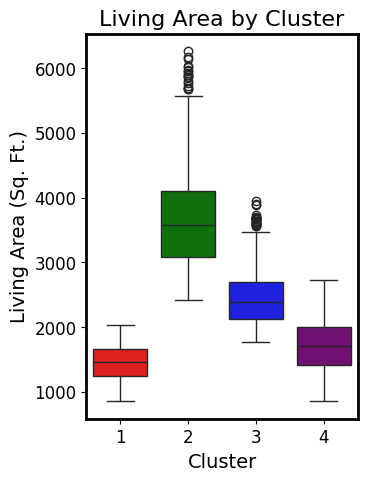

In [18]:
# make boxplot similar to above
plt.figure(figsize = (3.5, 5))
colors = [color_map[cluster] for cluster in range(4)]
bp = sns.boxplot(x = 'cluster', y = 'TOT_LVG_AREA', data = lotla_clusters, palette=colors, hue='cluster')
# make colors of the boxes match the density plot
plt.title("Living Area by Cluster", fontsize=16)
# make x ticks integers
plt.xticks(range(4), range(1, 5))
# hide legend
plt.legend([],[], frameon=False)
# make the tick labels bigger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# make labels bigger
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Living Area (Sq. Ft.)", fontsize=14)
plt.savefig("images/sqft.pdf", format='pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_2963557/2079370836.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x = lotla_clusters['cluster'], y = y_miami, palette=colors)


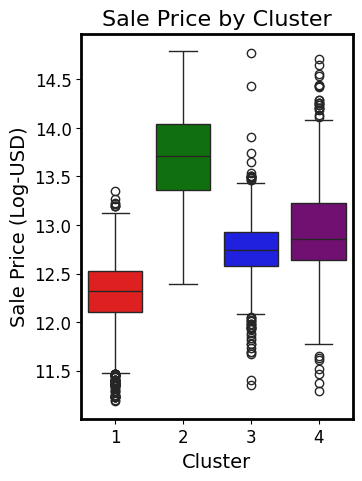

In [19]:
# make boxplot similar to above
plt.figure(figsize = (3.5, 5))
colors = [color_map[cluster] for cluster in range(4)]
bp = sns.boxplot(x = lotla_clusters['cluster'], y = y_miami, palette=colors)
# make colors of the boxes match the density plot
plt.title("Sale Price by Cluster", fontsize=16)
# make x ticks integers
plt.xticks(range(4), range(1, 5))
# hide legend
plt.legend([],[], frameon=False)
# make the tick labels bigger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# make labels bigger
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Sale Price (Log-USD)", fontsize=14)
plt.savefig("images/price.pdf", format='pdf', bbox_inches='tight')
plt.show()


/tmp/ipykernel_2963557/4046427777.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(x = lotla_clusters['cluster'], y = np.exp(y_miami), palette=colors)


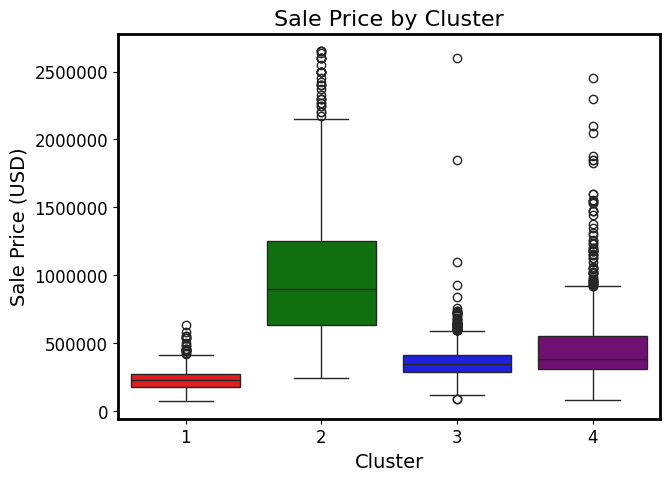

In [20]:
# make boxplot similar to above
plt.figure(figsize = (7, 5))
colors = [color_map[cluster] for cluster in range(4)]
bp = sns.boxplot(x = lotla_clusters['cluster'], y = np.exp(y_miami), palette=colors)
# make colors of the boxes match the density plot
plt.title("Sale Price by Cluster", fontsize=16)
# make x ticks integers
plt.xticks(range(4), range(1, 5))
# hide legend
plt.legend([],[], frameon=False)
# make the tick labels bigger
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# make labels bigger
plt.xlabel("Cluster", fontsize=14)
plt.ylabel("Sale Price (USD)", fontsize=14)
# make y-axis ticks not in scientific notation
plt.ticklabel_format(style='plain', axis='y')
plt.show()


In [22]:
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(lotla_clusters.iloc[:, 0], lotla_clusters.iloc[:, 1], lotla_clusters.loc[:, 'cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
# add legend to map with colors
# legend_dict = {f"Cluster {i+1}": color_map[i] for i in range(4)}
# m.add_legend(title = "Legend Title", legend_dict = legend_dict)
# m
# Define the legend's HTML
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 110px; height: 85px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 1.0;">
     &nbsp; Cluster #1 &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
     &nbsp; Cluster #2 &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
     &nbsp; Cluster #3 &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
     &nbsp; Cluster #4 &nbsp; <i class="fa fa-circle" style="color:purple"></i>
</div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))
m
# save the map to an HTML file
m.save("images/miami_clusters.html")

In [ ]:
color_map = {0: 'red', 1: 'green', 2: 'blue', 3: 'purple'}
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, cluster in zip(shap_clusters.iloc[:, 0], shap_clusters.iloc[:, 1], shap_clusters.loc[:, 'cluster']):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=color_map[cluster],
        fill=True,
        fill_color=color_map[cluster],
        fill_opacity=0.6
    ).add_to(m)
# add legend to map with colors
# legend_dict = {f"Cluster {i+1}": color_map[i] for i in range(4)}
# m.add_legend(title = "Legend Title", legend_dict = legend_dict)
# m
# Define the legend's HTML
legend_html = '''
<div style="position: fixed; 
     bottom: 50px; right: 50px; width: 110px; height: 85px; 
     border:2px solid grey; z-index:9999; font-size:14px;
     background-color:white; opacity: 1.0;">
     &nbsp; Cluster #1 &nbsp; <i class="fa fa-circle" style="color:red"></i><br>
     &nbsp; Cluster #2 &nbsp; <i class="fa fa-circle" style="color:green"></i><br>
     &nbsp; Cluster #3 &nbsp; <i class="fa fa-circle" style="color:blue"></i><br>
     &nbsp; Cluster #4 &nbsp; <i class="fa fa-circle" style="color:purple"></i>
</div>
'''

# Add the legend to the map
m.get_root().html.add_child(folium.Element(legend_html))
m

In [ ]:
# get boxplot of y values for each cluster
y_clusters = pd.DataFrame(np.exp(y_miami))
y_clusters['cluster'] = labels_lotla
fig, ax = plt.subplots()
y_clusters.boxplot(column = 0, by = 'cluster', ax = ax)
ax.set_title("Sale Price")
ax.set_ylabel("Price")
ax.set_xlabel("Cluster")
plt.suptitle("")
plt.show()

In [ ]:
colormap = branca.colormap.linear.YlOrRd_09.scale(min(np.exp(y_miami)), max(np.exp(y_miami)))

In [ ]:
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, y_val in zip(lotla_clusters.iloc[:, 0], lotla_clusters.iloc[:, 1], np.exp(y_miami)):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=colormap(y_val),
        fill=True,
        fill_color=colormap(y_val),
        fill_opacity=0.6
    ).add_to(m)
m

In [ ]:
colormap = branca.colormap.linear.YlOrRd_09.scale(min(y_miami), max(y_miami), max_labels=5)
m = folium.Map(location=[25.7, -80.3], zoom_start=10)
for lat, lon, y_val in zip(lotla_clusters.iloc[:, 0], lotla_clusters.iloc[:, 1], y_miami):
    folium.CircleMarker(
        [lat, lon],
        radius=1,
        color=colormap(y_val),
        fill=True,
        fill_color=colormap(y_val),
        fill_opacity=0.6
    ).add_to(m)
colormap.caption = "Sale Price (Log-USD)"
colormap.add_to(m)
colormap.width = 300
svg_style = '<style>svg#legend {font-size: 14px; background-color: white;}</style>'
m.get_root().header.add_child(folium.Element(svg_style))
m

In [ ]:
# plot histogram of y_miami
plt.hist(np.exp(y_miami), bins = 20)
plt.xlabel("Sale Price (Dollars)")
# make x-ticks vertical
plt.xticks(rotation = 90)
# make x-ticks 0, 500000, 1000000, 1500000, 2000000, 2500000
# plt.xticks([0, 500000, 1000000, 1500000, 2000000, 2500000])
# remove the 1e6
plt.gca().get_xaxis().get_major_formatter().set_scientific(False)
plt.ylabel("Frequency")
plt.title("Histogram of Sale Price")
plt.show()

In [ ]:
# plot histogram of y_miami
plt.hist(y_miami, bins = 20)
plt.xlabel("Sale Price (Log-Dollars)")
plt.ylabel("Frequency")
plt.title("Histogram of Sale Price")
plt.show()